## Data preparation and preprocessing

### Short introduction

We are the Conloquor team, which means dialogue in latin. We will be developing a chatbot for our project this semester.

Members:

- Béres Bálint
- Drexler Konrád
- Drexler Kristóf

### Data source

We found a dataset on [reddit](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/)
which includes all the reddit comments categorized by month. A user uploaded the entire dataset to google's
bigquery platform, here's the [reddit](https://www.reddit.com/r/bigquery/comments/3cej2b/17_billion_reddit_comments_loaded_on_bigquery/)
thread.

### Downloading the data

We chose to use comments from may, 2015 for our project. For this we ran the following SQL query on the bigquery platform.

```SQL
select *
from `fh-bigquery.reddit_comments.2015_05`
where subreddit like 'science'
    or subreddit like 'politics'
    or subreddit like 'gaming'
    or subreddit like 'worldnews'
    or subreddit like 'CasualConversation'
    or subreddit like 'sports'
```

At first we downloaded all the comments made that month, but the resulting file was 5GB compressed.
Therefore, we limited the source subreddits to **r/science**, **r/politics**, **r/gaming**,
**r/worldnews**, **r/CasualConversation** and **r/sports**. This query still yielded 1.45 million
comments to work with, but was a manageable size. We exported the resulting table to a json file;
 `data_2015_05.json`. This `.json` is available on my [google drive](https://drive.google.com/file/d/13n1ET0mppD6i-DjqyJIFjAiMQp6V7v6q/view?usp=sharing).
 In the future, the project will automatically download the data.

## Formatting the data for preprocessing

The initial json file still had a lot of unnecessary columns and unusable rows. Using further SQL queries we
trimmed and transformed the data to fit our needs. At the end of the process we were left with just short of
480000 message-response pairs. This was done by by filtering out messages longer than 200 characters, [deleted] messages
and hyperlink only messages to name a few.

In [7]:
# pandasql is not in the google colab repertoir by default, it needs to be installed manually
!pip install pandasql

In [8]:
# import statements
import pandas as pd
import pandasql as ps

In [11]:
# Create dataframe from json file
raw_data_df = pd.read_json(r'data_2015_05.json', orient='records', lines=True)

In [ ]:
# Show top ten rows
raw_data_df.head(10)

,body,score_hidden,archived,name,author,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,author_flair_text,author_flair_css_class,distinguished
0,That wasn't just a personal belief of his. It'...,False,False,t1_cr7h0ln,tejon,0,1431494075,t5_2cneq,t3_35ql9d,t1_cr7fnj4,136,1433034878,0,0,cr7h0ln,politics,136,NaN,NaN,NaN
1,I think you're on to something there. But to b...,False,False,t1_crpxkmu,Tangpo,0,1432999141,t5_2cneq,t3_37tyhm,t1_crpw8y8,17,1433393342,0,0,crpxkmu,politics,17,NaN,NaN,NaN
2,They've also been rather clear on defining a f...,False,False,t1_cr43h2c,Qu1nlan,0,1431220695,t5_2cneq,t3_35eepj,t1_cr439ea,19,1432870611,0,0,cr43h2c,politics,19,NaN,NaN,NaN
3,God bless you.,False,False,t1_cr5rn0g,broncoz33,0,1431370502,t5_2qh03,t3_35liga,t1_cr5qa14,13,1432899458,0,0,cr5rn0g,gaming,13,NaN,NaN,NaN
4,Western corporations don't give a rats arse to...,False,False,t1_cra1d35,critfist,0,1431701414,t5_2qh13,t3_361cco,t1_cra0qd0,-4,1433079241,0,0,cra1d35,worldnews,-4,NaN,NaN,NaN
5,[deleted],False,False,t1_cqvze0l,[deleted],0,1430571181,t5_2qh13,t3_34lnbr,t1_cqvye5y,-3,1432729493,0,0,cqvze0l,worldnews,-3,NaN,NaN,NaN
6,http://en.wikipedia.org/wiki/Celebration_Cruis...,False,False,t1_crqsdm6,Atheist101,0,1433078136,t5_323oy,t3_37v2sr,t1_crqdes4,-4,1433496812,0,0,crqsdm6,CasualConversation,-4,NaN,NaN,NaN
7,"I'm not attacking them, I'm making an observat...",False,False,t1_crahjf8,utb040713,0,1431728711,t5_mouw,t3_3622fk,t1_cragizb,0,1433087005,0,0,crahjf8,science,0,NaN,NaN,NaN
8,"Well, that's a vile and disgusting thing to sa...",False,False,t1_cr4qp74,Fractal_Soul,0,1431286132,t5_2cneq,t3_35ffem,t1_cr4div8,0,1432881767,0,0,cr4qp74,politics,0,NaN,NaN,NaN
9,Are you 15? Lol,False,False,t1_crcbtar,chuchubaba,0,1431900496,t5_2qh03,t3_369dwg,t1_crc88ht,0,1433118815,0,0,crcbtar,gaming,0,NaN,NaN,NaN


In [ ]:
# Filter raw data:
# select only rows which have a length less than 200, and the comment wasn't [deleted]
sql_query = " select body" \
            "       , name" \
            "       , link_id" \
            "       , parent_id" \
            "       , score" \
            " from raw_data_df" \
            " where length(body) < 200 and body <> '[deleted]'"
# Can only be saved as sdf since this is how pandas works.
sdf = ps.sqldf(sql_query)

In [ ]:
# Delete the original Dataframe to save memory
del raw_data_df

In [ ]:
# List of regular expressions to further filter the bodies of the comments;

# Remove all links from the comments
sdf.replace(r'https?://(www.)?[-a-zA-Z0-9@:%.+~#=]{1,256}.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9(_)@:%+.~#?&//=]*)','',regex=True, inplace = True)

# Remove all user links/subreddit links
sdf.replace(r'(/u/)?(r/)?(^)?(\\)?','',regex=True, inplace = True)

# Replace '&gt;' and '&lt' with '<' and '>' respectively
sdf.replace(r'(&gt;)','>',regex=True, inplace = True)
sdf.replace(r'(&lt)','<',regex=True, inplace = True)

# Replace '&amp' with an ampersand
sdf.replace(r'(&amp;)','&',regex=True, inplace = True)

In [ ]:
# Rename body column to response
response_df = sdf.rename(columns={'body': 'response'})

In [ ]:
# Show top ten rows
response_df.head(10)

,response,name,link_id,parent_id,score
0,They've also been rather clear on defining a f...,t1_cr43h2c,t3_35eepj,t1_cr439ea,19
1,God bless you.,t1_cr5rn0g,t3_35liga,t1_cr5qa14,13
2,Western corporations don't give a rats arse to...,t1_cra1d35,t3_361cco,t1_cra0qd0,-4
3,,t1_crqsdm6,t3_37v2sr,t1_crqdes4,-4
4,"Well, that's a vile and disgusting thing to sa...",t1_cr4qp74,t3_35ffem,t1_cr4div8,0
5,Are you 15? Lol,t1_crcbtar,t3_369dwg,t1_crc88ht,0
6,"Oh okay, cause a lot of people post similar ""t...",t1_crjr1yc,t3_372bqp,t1_crj8tdk,0
7,> according to analysts who monitor web chatte...,t1_cr2nszt,t3_357t9u,t3_357t9u,0
8,"Minavo Communications provides IVR solutions, ...",t1_cr5cntq,t3_35kx45,t3_35kx45,1
9,"Pfft, Convolvulaceae is where it's at. ;-)",t1_crmt7hn,t3_37gbrz,t1_crmsccb,1


In [ ]:
# Create query-response pairs
# Join the two tables to make a single one
# Concatenate '<eos>' to the end, and '<sos>' to the start of the response and store each of them, in a different column
sql_query = " select inp.body" \
            "       , resp.response || ' <eos>'" \
            "       , '<sos> ' || resp.response" \
            " from response_df resp" \
            " left join sdf inp" \
            " on resp.parent_id = inp.name" \
            " where inp.body is not null and inp.body <> '' and resp.response <> ''"
# Can only be saved as sdf since this is how pandas works.
sdf = ps.sqldf(sql_query)

In [ ]:
# Rename body to input, second column to output and third column to output_input
xy_df = sdf.rename(columns={'body': 'input', "resp.response || ' <eos>'": 'output', "'<sos> ' || resp.response": 'output_input'})

In [ ]:
# Delete sdf to free up memory
del sdf

In [ ]:
# show top ten rows of the new dataframe
xy_df.head(10)

,input,output,output_input
0,They've also been rather clear on defining a f...,"No, they have not. What gave you that idea? Th...","<sos> No, they have not. What gave you that id..."
1,Western corporations don't give a rats arse to...,"wow, ok have you ever heard of a thing called ...","<sos> wow, ok have you ever heard of a thing c..."
2,What was the conversation? I just killed them.,"""Something something something, then I raped t...","<sos> ""Something something something, then I r..."
3,Well it just shows us past behavior and what o...,"Guess you aren't a big believer in ""firsts""?\n...","<sos> Guess you aren't a big believer in ""firs..."
4,Solid advice to avoid a shaky end for TheEarth...,Agreed! <eos>,<sos> Agreed!
5,The whole schools discrimination provision was...,The fact my daughter is bottom of the list in ...,<sos> The fact my daughter is bottom of the li...
6,Hahaha yeah we can do that too. I just thought...,Nothing wrong with multitasking during a movie...,<sos> Nothing wrong with multitasking during a...
7,"Thank you!\n\nYeah, I like them and find them ...",Understandable. It's not a real exam if you do...,<sos> Understandable. It's not a real exam if ...
8,2 line pass.,False. But it was offside <eos>,<sos> False. But it was offside
9,Well shit... I never used boot bands to blouse...,My point exactly. <eos>,<sos> My point exactly.


In [10]:
# Export to a json file this is so we don't have to run all previous cells again
xy_df.to_json('xy_data_2015_05.json', orient='records', lines=True)

In [ ]:
# Delete all to free memory
del response_df
del xy_df
del sql_query

## Preprocessing

Now that we have a dataset of usable message-response pairs, lets preprocess the data. The tokenizer encodes words into numbers,
a seperate tokenizer is used for the the message data and the output data. Next, we padded the messages to have a fixed size for all of our messages.
The `.json` file created in the previous section can be downloaded from this [google drive](https://drive.google.com/file/d/1J65cyCx6Zp1AgzTCGrB1Oqye9nkokmot/view?usp=sharing) link.

In [12]:
# import statements
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
# Load data from the saved json file
xy_data_df = pd.read_json(r'xy_data_2015_05.json', orient='records', lines=True)

In [14]:
# for testing purposes we reduced the dataframe to the first 10000 comments
xy_data_df = xy_data_df[0:10000]  

In [15]:
# Check a random row from the dataframe
print(xy_data_df['input'][172])
print(xy_data_df['output'][172])
print(xy_data_df['output_input'][172])

Do tell. How is it not true? 
Other than character skins, how are they not just pre set loadouts? 
you could unlock extra guys. one had a jet-pack if I remember correctly and another had invisibility.  <eos>
<sos> you could unlock extra guys. one had a jet-pack if I remember correctly and another had invisibility. 


In [16]:
# set max number of words recognized by the model
MAX_NUM_WORDS = 5000

In [17]:
# Text from the input column is tokenized

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

# Tokenizer is fitted
input_tokenizer.fit_on_texts(xy_data_df['input'])

# Sequences are generated from the text
input_integer_seq = input_tokenizer.texts_to_sequences(xy_data_df['input'])

# { word: index} dictionary of the input_tokenizer
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

# Word count and max input sentence length are stored
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 11994
Length of longest sentence in input: 40


In [18]:
# Text from the output and output_input columns are tokenized
# the regex given is the default filter minus the '<' and '>' symbols,
# as these have been handled using SQL in the previous section
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n)')

# Tokenizer is fitted
output_tokenizer.fit_on_texts(pd.concat([xy_data_df['output'], xy_data_df['output_input']]))

# Sequences are generated from the text
output_integer_seq = output_tokenizer.texts_to_sequences(xy_data_df['output'])
output_input_integer_seq = output_tokenizer.texts_to_sequences(xy_data_df['output_input'])

# { word: index} dictionary of the output_tokenizer
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

# Word count and max output sentence length are stored
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 13878
Length of longest sentence in the output: 44


In [25]:
# input_integer_seq is padded which will be fed into the encoder
# max_input_len stores the maximum output sentence length
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (10000, 40)
encoder_input_sequences[172]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  30 288  39   5   9  16 210  92  77 551  39  14  24
  16  25 818 607]


In [26]:
# Example word indices from input_tokenizer
print(word2idx_inputs["ill"])
print(word2idx_inputs["skins"])

1766
6740


In [27]:
# output_input_integer_seq is padded which will be fed into the decoder
# max_out_len stores the maximum output sentence length
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (10000, 44)
decoder_input_sequences[172]: [   2    7  103 3228 1127  347   44   85    5 1542 2674   30    4  287
 2243    8  232   85    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [28]:
# Example word indices from output_tokenizer
print(word2idx_outputs["<eos>"])
print(word2idx_outputs["not"])
print(word2idx_outputs["correctly"])
# print(word2idx_outputs["invisibility"])

1
15
2243


The following two cells visualize the progress made up until this point

In [ ]:
subset_dict = {str(value): 0 for key, value in input_tokenizer.word_index.items()}
input_sequences = []

# The input and response sentences are tokenized 
# and the token occurrences are counted in subset_dict
for line in xy_data_df.iterrows():

    # Input tokenization
    token_list = input_tokenizer.texts_to_sequences([line[1][0]])[0]

    for token in token_list:
        subset_dict[str(token)] += 1

    # print('input')
    # print(token_list)
    # print(tokenizer.sequences_to_texts([token_list]))
    # print()

    # Response tokenization
    token_list = input_tokenizer.texts_to_sequences([line[1][1]])[0]

    # print('response')
    # print(token_list)
    # print(tokenizer.sequences_to_texts([token_list]))
    # print()

    for token in token_list:
        subset_dict[str(token)] += 1

the a i to is you and of it that in for this are be not on have but what like was with they just my so it's as


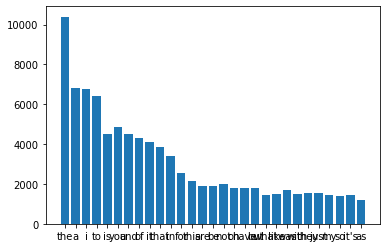

In [ ]:
import matplotlib.pyplot as plt

# A sequence from 0 to 29 is created
list_c = [i for i in range(30)]

# The string value of the 30 most used tokens are retrieved
example_seq = input_tokenizer.sequences_to_texts([list_c])[0]
print(example_seq)

# Turns the example_seq string into a list of words
x = example_seq.split()

# The 30 most popular words are plotted based on their occurrence
plt.bar(x, list(subset_dict.values())[:len(x)], align = 'center')
plt.show()

### Word embeddings

This is where our work for the second milestone starts. We relied heavily on [this](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/) guide on stackabuse. Although we made everal modifications to get it to work with our dataset.

The following section embeds the words recognized by the model in a vector with 100 dimensions.

In [19]:
# import statements
from numpy import array
from numpy import asarray
from numpy import zeros

In [20]:
# we used the pretrained vector embedding model GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip glove.6B.zip

--2020-11-21 13:46:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-21 13:46:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-21 13:46:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [21]:
# unzip the downloaded file
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [22]:
#set embedding size
EMBEDDING_SIZE = 100

In [23]:
# the embedding dictionary is a dictionary with the key being a word,
# and the value being the corresponding 100d vector
embeddings_dictionary = dict()

# open the file containing the 100d vectors
glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

# iterate over the lines in the file
for line in glove_file:
    records = line.split()  # split along whitespaces
    word = records[0]       # the word itself is the first element of the list
    # the vector representation is the rest of the elements
    vector_dimensions = asarray(records[1:], dtype='float32')  
    embeddings_dictionary[word] = vector_dimensions  # insert word: vector representation into dictionary
glove_file.close()  # close GloVe file

In [24]:
# create the embedding matrix

# limit the number of words understood by the model to MAX_NUM_WORDS
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
# create embedding matrix filled with zeroes
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

# iterate over the first MAX_NUM_WORDS collected by the tokenizer
for word, index in list(word2idx_inputs.items())[:num_words-1]:
  # get embedding vector corresponding to the given word
  embedding_vector = embeddings_dictionary.get(word)
  # if embedding vector exists, the insert into relevant column of the mbedding matrix
  # null vector by default
  if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [55]:
# some testing
index = 4997

In [56]:
# print last word
print(list(word2idx_inputs.items())[index])

('superpowers', 4998)


In [57]:
# print embedding of word from the embedding dictionary
print(embeddings_dictionary[list(word2idx_inputs.items())[index][0]])

[ 8.2561e-01  7.0368e-01  1.0856e+00  1.8640e-01 -3.3048e-01 -1.1595e+00
 -4.0692e-02 -1.5319e-01  1.8652e-01 -3.2869e-01 -7.1025e-02 -4.5381e-01
  4.2302e-01  3.7044e-01  1.1495e-01 -2.8965e-01  3.6515e-01  4.5981e-01
 -1.7285e-01 -8.6656e-01  3.5760e-01  1.1741e-01  1.0402e-01 -1.6487e-01
  8.5793e-01  4.4120e-02 -3.1421e-01  4.0868e-01 -1.0667e-02 -9.8774e-02
  5.4666e-01 -1.0250e-01 -6.8991e-01 -6.8826e-01  3.0186e-01 -1.6146e-02
  1.5912e-01 -5.5968e-01 -5.7463e-01  1.5893e-02 -4.1537e-01  6.1719e-01
 -1.7870e-01 -4.5237e-01  1.6250e-01 -3.7825e-02  9.4251e-01  4.8348e-01
  2.3142e-01  2.6951e-01 -6.6098e-01  3.8090e-01 -4.2468e-01  7.1296e-01
  1.1183e+00  3.7083e-02  4.7085e-01 -4.0589e-01 -6.6160e-01  9.4728e-02
  1.2168e-01  5.2807e-01 -3.9111e-01  1.3211e-01 -5.3060e-02  2.4917e-01
 -2.5457e-01  4.3781e-04  1.5508e-01  2.7041e-01  5.7762e-02 -3.7124e-01
 -1.8106e-01  5.6205e-02 -8.4670e-01  9.5469e-03 -1.7227e-01 -7.2889e-01
 -5.0670e-01  2.1736e-01  3.8822e-01  1.4572e-02 -2

In [58]:
# print embedding of word from the embedding matrix
print(embedding_matrix[list(word2idx_inputs.items())[index][1]])

[ 8.25609982e-01  7.03679979e-01  1.08560002e+00  1.86399996e-01
 -3.30480009e-01 -1.15950000e+00 -4.06920016e-02 -1.53190002e-01
  1.86519995e-01 -3.28689992e-01 -7.10249990e-02 -4.53810006e-01
  4.23020005e-01  3.70440006e-01  1.14950001e-01 -2.89649993e-01
  3.65150005e-01  4.59809989e-01 -1.72849998e-01 -8.66559982e-01
  3.57600003e-01  1.17409997e-01  1.04020000e-01 -1.64869994e-01
  8.57930005e-01  4.41199988e-02 -3.14209998e-01  4.08679992e-01
 -1.06670000e-02 -9.87740010e-02  5.46660006e-01 -1.02499999e-01
 -6.89909995e-01 -6.88260019e-01  3.01860005e-01 -1.61460005e-02
  1.59119993e-01 -5.59679985e-01 -5.74630022e-01  1.58929992e-02
 -4.15369987e-01  6.17190003e-01 -1.78700000e-01 -4.52369988e-01
  1.62499994e-01 -3.78249995e-02  9.42510009e-01  4.83480006e-01
  2.31419995e-01  2.69510001e-01 -6.60979986e-01  3.80899996e-01
 -4.24679995e-01  7.12960005e-01  1.11829996e+00  3.70829999e-02
  4.70849991e-01 -4.05889988e-01 -6.61599994e-01  9.47280005e-02
  1.21679999e-01  5.28069

### Model structure
This section build the model and trains it based on the data compiled in the previous sections.

In [ ]:
# import statements
import numpy as np
from tensorflow.keras.layers import Embedding

In [ ]:
# create embedding layer from embedding matrix
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [ ]:
# get input sentences
input_sentences = xy_data_df['input']

# create null hypermatrix with dimensions:
# number of input sentences
# maximum word length of input sentences
# number of words
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words
    ),
    dtype='float32'
)

In [ ]:
# check shape
decoder_targets_one_hot.shape

(10000, 44, 5000)

In [ ]:
# pad output sequences to the same length,
# namely to the maximum length of the output sequences
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

In [ ]:
# fill the previously create null hypermatrix with one hot columns in the following fashion:
# Insert value 1 into every r-th row of every c-th column of every m-th matrix where;
# m is the index of the sentence in decoder_output_sequences: 1-st sentence -> m = 0, n-th sentence -> m = n-1
# c is the place of the word in the sentence: 1-st word in sentence -> c = 0, n-th word in sentence -> c = n-1
# r is the value given to the word by th output tokenizer: '<eos>' -> r = 1, 'not' -> r = 15

for m, sequence in enumerate(decoder_output_sequences):
    for c, r in enumerate(sequence):
        decoder_targets_one_hot[m, c, r] = 1

In [ ]:
# set number of LSTM nodes
LSTM_NODES = 256

In [ ]:
# import statements
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras import Model

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [ ]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [ ]:
decoder_dense = Dense(num_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

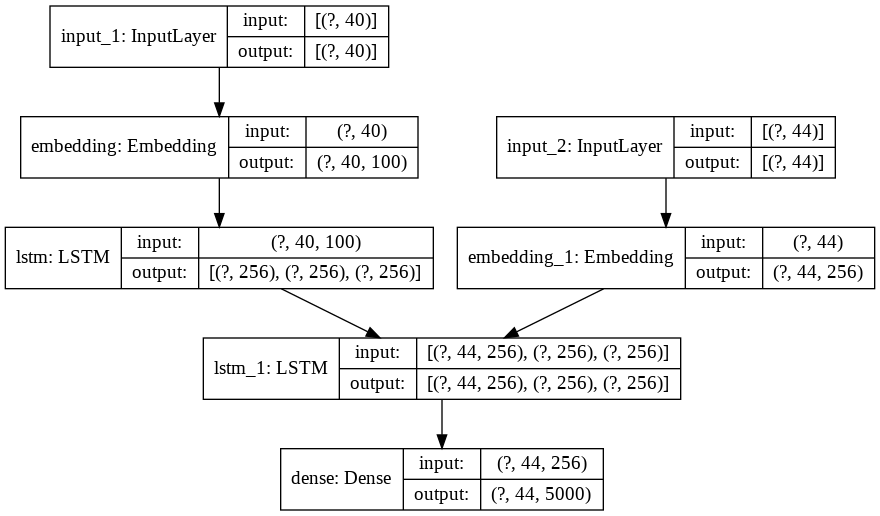

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

In [ ]:
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)
print(decoder_targets_one_hot.shape)

(10000, 40)
(10000, 44)
(10000, 44, 5000)


In [ ]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/20
141/141 [==============================] - 13s 90ms/step - loss: 2.1810 - accuracy: 0.7087 - val_loss: 1.8877 - val_accuracy: 0.7215
Epoch 2/20
141/141 [==============================] - 12s 84ms/step - loss: 1.8303 - accuracy: 0.7261 - val_loss: 1.8359 - val_accuracy: 0.7235
Epoch 3/20
141/141 [==============================] - 12s 84ms/step - loss: 1.7710 - accuracy: 0.7311 - val_loss: 1.7929 - val_accuracy: 0.7288
Epoch 4/20
141/141 [==============================] - 12s 84ms/step - loss: 1.7214 - accuracy: 0.7357 - val_loss: 1.7649 - val_accuracy: 0.7320
Epoch 5/20
141/141 [==============================] - 12s 84ms/step - loss: 1.6862 - accuracy: 0.7382 - val_loss: 1.7458 - val_accuracy: 0.7334
Epoch 6/20
141/141 [==============================] - 12s 85ms/step - loss: 1.6523 - accuracy: 0.7400 - val_loss: 1.7344 - val_accuracy: 0.7347
Epoch 7/20
141/141 [==============================] - 12s 85ms/step - loss: 1.6232 - accuracy: 0.7416 - val_loss: 1.7281 - val_accuracy:

### Encoder model structure

In [ ]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

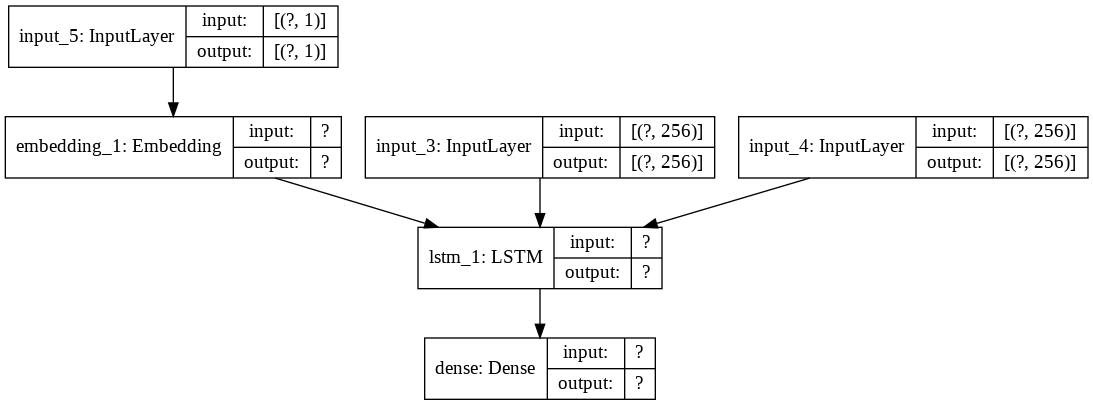

In [ ]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

### Evaluation
Evaluate a few input sentences

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: So then, in your opinion, are those members of Congress not actually true to conservative principles, or are the loud voices misrepresenting conservative principles? 
Response: because the government is not a lot of the us that is a lot of the us to get the us to get a lot of the


### Save model
This section saves and download the model. The saved model with this preliminary training is available in the github repository.

In [ ]:
# save model
model.save('model_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: content/model_1/assets


In [ ]:
# zip saved model
!zip -r /content/model_1.zip /content/model_1

  adding: content/content/model_1/ (stored 0%)
  adding: content/content/model_1/assets/ (stored 0%)
  adding: content/content/model_1/saved_model.pb (deflated 90%)
  adding: content/content/model_1/variables/ (stored 0%)
  adding: content/content/model_1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/content/model_1/variables/variables.index (deflated 64%)


In [ ]:
# download saved model
from google.colab import files
files.download('model_1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>